# Train model

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.trainer.utils.plot_history import plot_history_cytoself

/dgx1nas1/storage/data/jess/miniforge3/envs/cytoself/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Input parameters
data_ch = ["pro", "nuc"]
#datapath = '/dgx1nas1/storage/data/jess/cytoself/model_data' # Entire manuscript dataset
datapath = "/dgx1nas1/storage/data/jess/cytoself/data_10per" # 10% of manuscript dataset
#datapath = '/dgx1nas1/storage/data/jess/repos/cytoself/sample_data' # 10 proteins, each downsampled
outputpath = "/dgx1nas1/storage/data/jess/cytoself/trained_models"
#model_nm = "demo_output"
model_nm = "data_10percent_5epoch"

# Define datamanager
datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
datamanager.const_dataloader(batch_size=32, label_name_position=1)

Loading pro data...


100%|██████████| 131/131 [00:14<00:00,  8.75it/s]


Loading nuc data...


100%|██████████| 131/131 [00:12<00:00, 10.66it/s]


Loading label data...


100%|██████████| 131/131 [00:00<00:00, 1741.57it/s]


Splitting data...
Computing variance of training data...
Computing variance of validation data...
Computing variance of test data...


In [3]:
# Train model

model_args = {
    "input_shape": (2, 100, 100),
    "emb_shapes": ((25, 25), (4, 4)),
    "output_shape": (2, 100, 100),
    "fc_output_idx": [2],
    "vq_args": {"num_embeddings": 512, "embedding_dim": 64},
    "num_class": len(datamanager.unique_labels),
    "fc_input_type": "vqvec",
}
train_args = {
    "lr": 0.0004,
    "max_epoch": 2,
    "reducelr_patience": 4,
    "reducelr_increment": 0.1,
    "earlystop_patience": 12,
}
trainer = CytoselfFullTrainer(train_args, homepath=f"{outputpath}/{model_nm}", model_args=model_args)
trainer.fit(datamanager, tensorboard_path="tb_logs")

Epoch 1/2


  Val: 100%|██████████| 412/412 [00:15<00:00, 26.55it/s]


A model checkpoint has been saved at /dgx1nas1/storage/data/jess/cytoself/trained_models/data_10percent_5epoch/checkpoints/checkpoint_ep1.chkp
Epoch 2/2


  Val: 100%|██████████| 412/412 [00:15<00:00, 26.66it/s]


A model checkpoint has been saved at /dgx1nas1/storage/data/jess/cytoself/trained_models/data_10percent_5epoch/checkpoints/checkpoint_ep2.chkp


 Test: 100%|██████████| 345/345 [00:12<00:00, 26.90it/s]


A model has been saved at /dgx1nas1/storage/data/jess/cytoself/trained_models/data_10percent_5epoch/model_2.pt


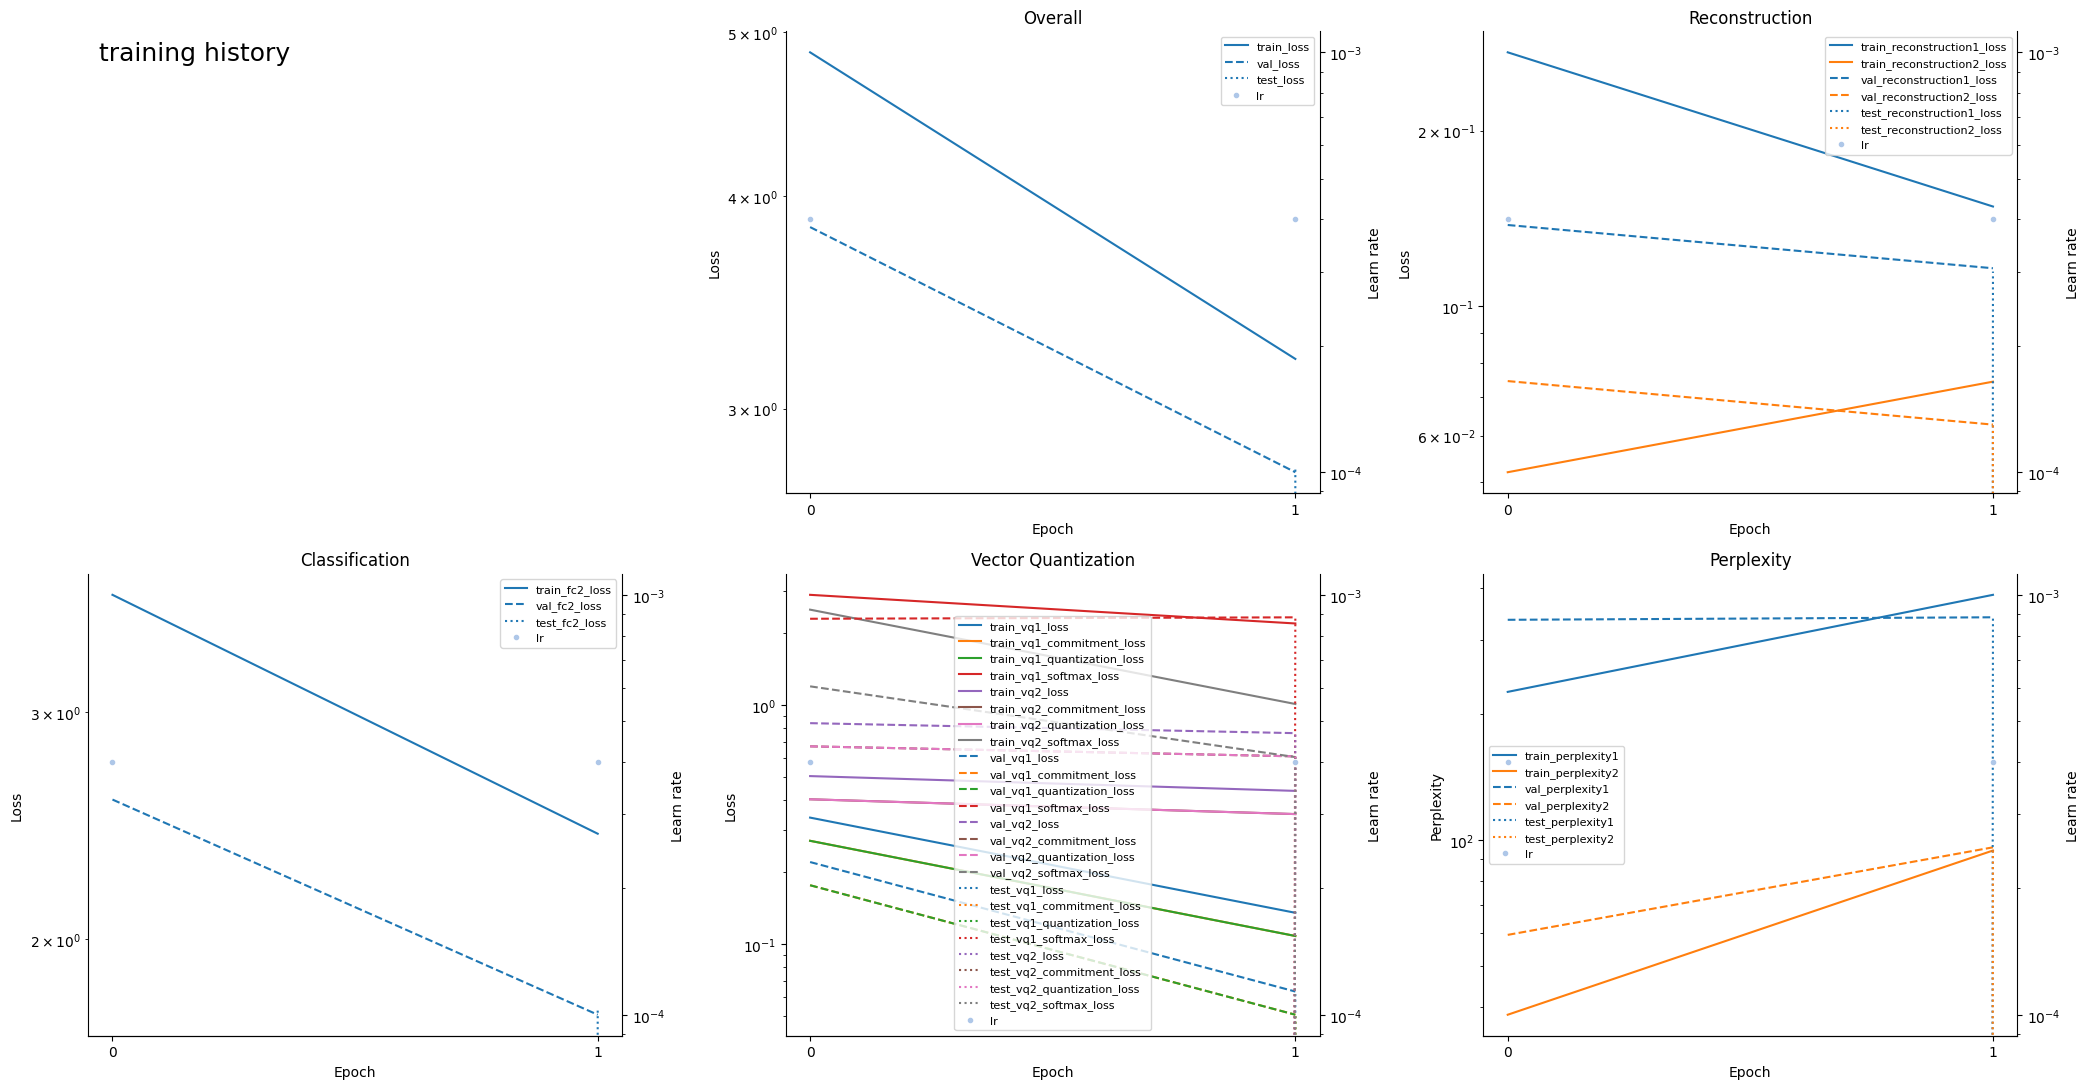

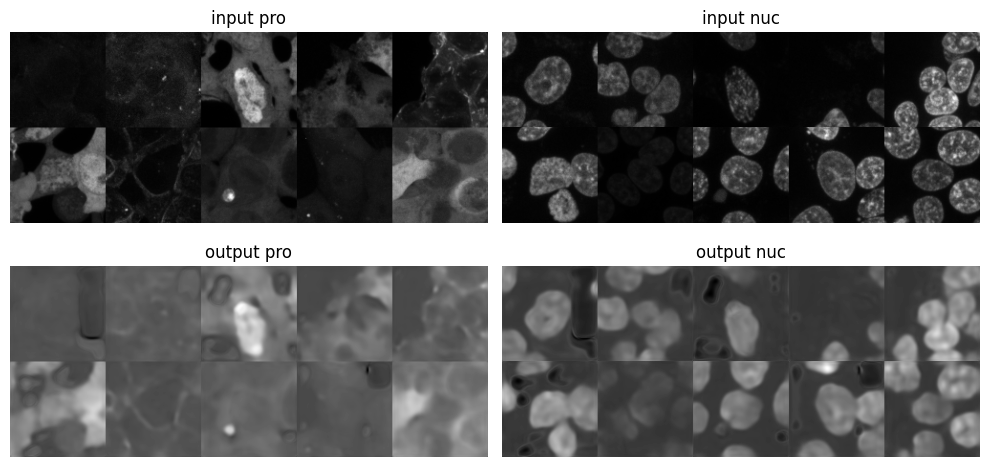

In [4]:
# 2.1 Generate training history
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict["visualization"])

# 2.2 Compare the reconstructed images as a sanity check
img = next(iter(datamanager.test_loader))["image"].detach().cpu().numpy()
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap="gray")
    ax[0, ii].axis("off")
    ax[0, ii].set_title("input " + ch)
    ax[1, ii].imshow(t1, cmap="gray")
    ax[1, ii].axis("off")
    ax[1, ii].set_title("output " + ch)
fig.tight_layout()
fig.show()
fig.savefig(Path(trainer.savepath_dict["visualization"]) / "reconstructed_images.png", dpi=300)

Infer: 100%|██████████| 345/345 [00:03<00:00, 103.87it/s]


Computing cell line ID vs vq index...


100%|██████████| 131/131 [00:00<00:00, 2101.67it/s]


Computing self Pearson correlation...


  0%|          | 0/512 [00:00<?, ?it/s]/dgx1nas1/storage/data/jess/repos/cytoself/cytoself/analysis/utils/pearson_correlation.py:30: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr[:, ii + offset] = pearsonr(array, row)[0]
100%|██████████| 512/512 [01:49<00:00,  4.68it/s]
/dgx1nas1/storage/data/jess/miniforge3/envs/cytoself/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


computing clustermaps...


/dgx1nas1/storage/data/jess/miniforge3/envs/cytoself/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


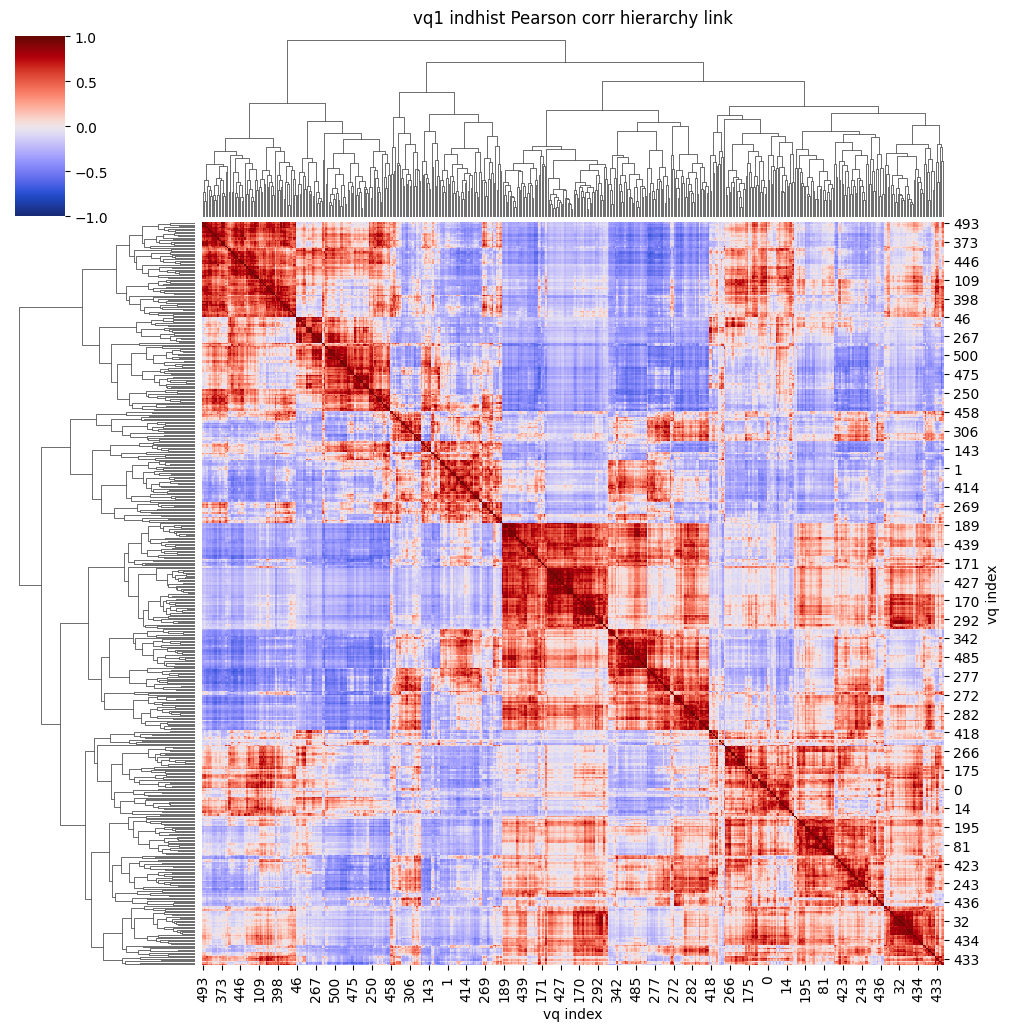

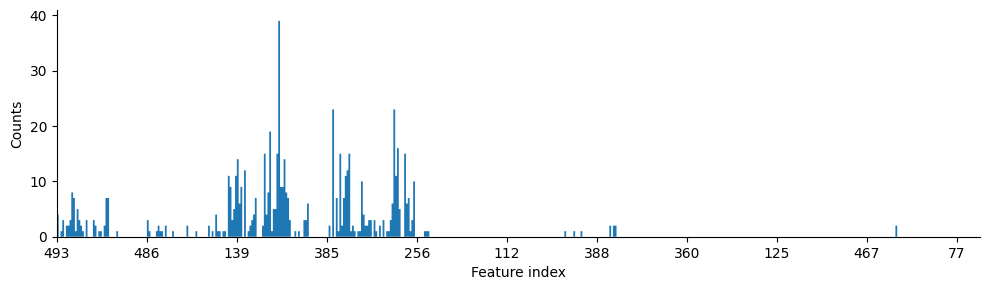

In [19]:
# 3. Analyze embeddings
analysis = AnalysisOpenCell(datamanager, trainer)

# 3.1 Generate bi-clustering heatmap
analysis.plot_clustermap(num_workers=4)

# 3.2 Generate feature spectrum
vqindhist1 = trainer.infer_embeddings(img, "vqindhist1")
ft_spectrum = analysis.compute_feature_spectrum(vqindhist1)

x_max = ft_spectrum.shape[1] + 1
x_ticks = np.arange(0, x_max, 50)
fig, ax = plt.subplots(figsize=(10, 3))
ax.stairs(ft_spectrum[0], np.arange(x_max), fill=True)
ax.spines[["right", "top"]].set_visible(False)
ax.set_xlabel("Feature index")
ax.set_ylabel("Counts")
ax.set_xlim([0, x_max])
ax.set_xticks(x_ticks, analysis.feature_spectrum_indices[x_ticks])
fig.tight_layout()
fig.show()
fig.savefig(Path(analysis.savepath_dict["feature_spectra_figures"]) / "feature_spectrum.png", dpi=300)

Computing embeddings from image...


Infer: 100%|██████████| 345/345 [00:05<00:00, 59.34it/s]


embeddings vqvec2 have been saved at /dgx1nas1/storage/data/jess/cytoself/trained_models/data_10percent_5epoch/embeddings
Computing UMAP coordinates from embeddings...
UMAP( verbose=True)
Sat Jul 13 00:35:01 2024 Construct fuzzy simplicial set
Sat Jul 13 00:35:01 2024 Finding Nearest Neighbors
Sat Jul 13 00:35:01 2024 Building RP forest with 10 trees
Sat Jul 13 00:35:01 2024 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Sat Jul 13 00:35:01 2024 Finished Nearest Neighbor Search
Sat Jul 13 00:35:01 2024 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:07]


Sat Jul 13 00:35:09 2024 Finished embedding
EDITED


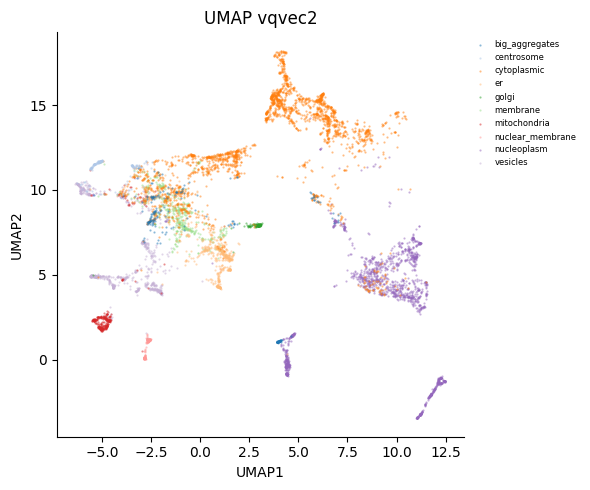

In [20]:
%reload_ext autoreload

analysis = AnalysisOpenCell(datamanager, trainer)

umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel="UMAP1",
    ylabel="UMAP2",
    s=0.3,
    alpha=0.5,
    show_legend=True,
)